In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless
import pandas as pd


## Plot EXP2

### Function definitions

In [4]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

def get_exp_results(r_det, alternate_analysis = False):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    print('gen err list shape:',gen_err_list.shape)
    
    # K_g = np.max(np.mean(np.array(grad_list), 0))
    # L_g = np.max(np.mean(np.array(hess_list), 0))
    
    # IMP: note that here we use older paper's notation where K_g is lipschitz constant(L_S) and L_g is the smoothness constant (K_S)
    K_g = np.max(np.max(np.array(grad_list), 1))
    L_g = np.max(np.max(np.array(hess_list), 1))
    
    if alternate_analysis:
        # For alternate analysis we compute the average Lipschitz constant acc to latest paper (L_{S,I_0})
        # i.e., E_{w_0,r}[L_{S,I_0}]  (there will be other variables in expectation as well)
        K_st = np.sqrt(np.mean(np.mean(np.power(np.array(grad_list),2),1)))
    
    K_g_avg = np.mean(grad_list)
    L_g_avg = np.mean(hess_list)
    K_g_run_avg = []
    L_g_run_avg = []
    for i, kgi in enumerate(np.max(grad_list, 0)):
        temp = np.sqrt(np.mean(np.mean(np.power(grad_list,2), 0)[:i+1]))
        K_g_run_avg.append(temp)
    for i,lgi in enumerate(np.max(hess_list, 0)):
        temp = np.mean(np.max(hess_list, 0)[:i+1])
        L_g_run_avg.append(temp)
        
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by

    if alternate_analysis:
        return grad_list, hess_list, K_st, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg
    else:
        return grad_list, hess_list, K_g, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg
    




In [5]:
from scipy.special import gammaincc as incomplete_gamma

def clac_U(x, rho, alpha_0, L_g):

    # if(1-2*rho <0):
        ## very small value of m
        # return 1 + 1/(L_g*alpha_0)
    base_const = np.exp(-2*alpha_0*L_g/rho)
    gamma_const = (1/(1-2*rho))*np.power(2*alpha_0*L_g/rho, (1/rho - 2))
    gamma_function = incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g* np.power(x, rho)/rho) - incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g/rho)
    
    return base_const + gamma_const* gamma_function
    


In [6]:
from scipy.special import gammaincc as incomplete_gamma

def clac_U(x, rho, alpha_0, L_g, way = 'other'):

    # print(f'{1 - 2*rho =}')
    # if(1-2*rho <0):
        ## very small value of m
        # return 1 + 1/(L_g*alpha_0)
    if way == 'other':
        base_const = np.exp(-2*alpha_0*L_g/rho)
        temp_res = 0
        for i in range(2, x+1):
            temp_res += np.exp(-2 *alpha_0 * L_g * np.power(i, rho)/rho)/np.power(i, 1-rho)
        
        return base_const + temp_res
            

    else:
        base_const = np.exp(-2*alpha_0*L_g/rho)
        gamma_const = (1/(1-2*rho))*np.power(2*alpha_0*L_g/rho, (1/rho - 2))
        input_1 = (2*rho -1)/rho
        input_2 = 2*alpha_0*L_g /rho
        print(f'{input_1=}, {input_2=}')
        gamma_function = incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g* np.power(x, rho)/rho) - incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g/rho)
        print(f'{gamma_function=}')
    
    return base_const + gamma_const* gamma_function

def our_bound_computatio(K_g, L_g, m, t, alpha_0, way='normal'):
    '''
    IMP: (Here we use older paper's notation)
        K_g = lipschitz constant 
        L_g = smoothness constant
    '''
    beta = 1
    alpha_lg = alpha_0*L_g
    # print('alpha_0 L_g (<=0.25?):',alpha_lg)
    if way == 'normal':
        F = np.power(t/m, 2*alpha_lg)
        F = F*np.power(2, t/m)
        # print('F', F)
        beta = (1+alpha_lg)*np.power(K_g,2)/L_g
        beta = beta* F/(np.power(m, 1-2*alpha_lg))
    est_gen_err = beta + 2*beta*np.sqrt(m)
    return est_gen_err

# New bound computation method


def get_bound(r_det, K_g, L_g, version = None):
    alpha_0 = r_det['alpha_0']
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            if version == 'TMLR':
                x_values.append(i+10)
            else:
                x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    x_values = np.array(x_values)
    print('x value shape:', x_values.shape)        
    m = x_values
    t = m
    # print('shape of m',m.shape)
    # print('m:',m)
    if version is None:
        bound = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)
    # elif version == 'TMLR':
    #     bound = our_bound_computation_tmlr(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0, way = 'optimistic')
    return bound

def plot_bound_gen_err(bound, gen_error, path=None, ylimits = None, x_values=None, title=None):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_yscale('log')
    fontsize = 40
    ticksize = 24
    line_width = 6
    marker_size = 12
    if ylimits is not None:
        ax.set_ylim(ylimits[0],ylimits[1])
    if x_values is None:
        x_values = range(len(gen_error[0]))
    # ax.grid()
    sns.set_style("darkgrid")
    plt.plot(x_values, bound, label= 'Theoretical Upper Bound')
    plt.plot(x_values, np.abs(np.mean(gen_error, axis=0)), label='Observed Generalization Error')
    plt.xlabel('Number of Datapoints', fontsize=fontsize)
    plt.ylabel('Generalization error', fontsize=fontsize)
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    plt.xticks(rotation=10, size= ticksize)
    plt.yticks(size=ticksize)
    # ax.set_yticks(ax.get_yticks()[1:])
    # ax.set_yticklabels(ax.get_yticks(), size = ticksize)
    # ax.set_yscale('log')
    plt.xlim(-100, plt.xlim()[1])
    ax.legend(fontsize=ticksize)
    # ax.legend()
    plt.tight_layout()
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if path is not None:
        plt.savefig(path, pad_inches=0)

In [10]:
from scipy.special import gammaincc as incomplete_gamma

def clac_U(x, rho, alpha_0, L_g, way = 'other'):

    # print(f'{1 - 2*rho =}')
    # if(1-2*rho <0):
        ## very small value of m
        # return 1 + 1/(L_g*alpha_0)
    if way == 'other':
        base_const = np.exp(-2*alpha_0*L_g/rho)
        temp_res = 0
        for i in range(2, x+1):
            temp_res += np.exp(-2 *alpha_0 * L_g * np.power(i, rho)/rho)/np.power(i, 2-2*rho)
        
        return base_const + temp_res
            

    else:
        base_const = np.exp(-2*alpha_0*L_g/rho)
        gamma_const = (1/(1-2*rho))*np.power(2*alpha_0*L_g/rho, (1/rho - 2))
        input_1 = (2*rho -1)/rho
        input_2 = 2*alpha_0*L_g /rho
        print(f'{input_1=}, {input_2=}')
        gamma_function = incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g* np.power(x, rho)/rho) - incomplete_gamma((2*rho -1)/rho, 2*alpha_0*L_g/rho)
        print(f'{gamma_function=}')
    
    return base_const + gamma_const* gamma_function

def get_exp_results_tmlr(r_det, avg_lp = 'avg'):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    print('gen err list shape:',gen_err_list.shape)
    
    # IMP: note that here we use older paper's notation where K_g is lipschitz constant(L_S) and L_g is the smoothness constant (K_S)
    # We use the new notation i.e., L_g, and L_S are lipschitz constant and K_s is the smoothness constant
    # print(f'{grad_list.shape=}')
    if avg_lp == 'avg':
        L_s = []
        L_g = []
        for i in range(grad_list.shape[1]):
            L_s.append(np.mean(np.power(grad_list[:,:i+1],2)))
            L_g.append(np.mean(grad_list[:,i]))
        L_s = np.sqrt(np.array(L_s))
        L_g = np.array(L_g)
    elif avg_lp == 'arg_max':
        L_s = np.max(np.max(grad_list, 1))
        L_g = np.max(grad_list)
        
    K_s = np.max(np.max(hess_list,1))
    
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by

    return L_g, L_s, K_s, x_values, gen_err_list


def our_bound_computation_tmlr(L_s, L_g, K_s, m, t, alpha_0, way= 'avg'):
    beta = 1
    if way == 'arg_max':
        alpha_lg = alpha_0 * K_s
        rho = np.log(np.log(m))/np.log(m)
        U = 1 + 1/(alpha_lg)
        beta = np.power(2,np.ceil(t/m))*alpha_0*L_s*L_g*U* np.power(np.log(m),2) * np.power(m, alpha_lg/rho)
        est_gen_err = beta /m
    elif way == 'avg':
        # assuming L_s is squared avg and then sqrt is taken, i.e.,
        # sqrt(E[k_g^2])
        K_s = K_s
        m = m+10
        U = np.sqrt(1 + 1/(2*alpha_0 * K_s))
        m_exp = 0.5 - alpha_0 * K_s * (np.log(m) -1)/np.log(np.log(m))
        # print(f'{m_exp=}')
        est_gen_err = alpha_0 * L_s*L_g* U * np.power(np.log(m),2) / np.power(m, m_exp)
    elif way == 'exact_sum':
        # Using best possible value of U (Calculating summation)
        # assuming L_s is squared avg and then sqrt is taken, i.e.,
        # sqrt(E[L_s^2])
        est_gen_err = []
        skip_top = 10
        # K_s = np.max(K_s)
        for idx, x in enumerate(m[skip_top:]):
            if type(L_s) == list or type(L_s) == np.ndarray:
                # print(f'\n\n\n Taking ls as 1 element \n\n\n')
                tLs = L_s[idx+skip_top]
            else:
                tLs = L_s
            if type(L_g) == list or type(L_g) == np.ndarray:
                # print(f'\n\n\n Taking ls as 1 element \n\n\n')
                tLg = L_g[idx+skip_top]
            else:
                tLg = L_g

            rho = np.log(np.log(x))/np.log(x)
            # rho = alpha_0* K_s
            # U = np.exp(-2 * alpha_0* K_s/rho)
            U = clac_U(x,rho,alpha_0, K_s)
            # print(f'{U=}')
            temp_res = alpha_0 *tLs*tLg* U * np.power(np.log(x), 2)/np.power(x, 0.5 - alpha_0 * K_s/rho)
            # print(f'{temp_res=}')
            est_gen_err.append(temp_res)
        est_gen_err = [1]*skip_top + est_gen_err
        # print(est_gen_err)
        est_gen_err = np.array(est_gen_err)
        # print(est_gen_err)
    elif way == 'using_gamma_func':
        raise Exception('complete this function')
     
    return est_gen_err


def get_bound_tmlr(r_det, L_s, L_g, K_s, avg_lg = 'avg'):
    alpha_0 = r_det['alpha_0']
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            # if version == 'TMLR':
            #     x_values.append(i+10)
            # else:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    x_values = np.array(x_values)
    # print('x value shape:', x_values.shape)        
    m = x_values
    t = m
    # print('shape of m',m.shape)
    # print('m:',m)
    bound = our_bound_computation_tmlr(L_s = L_s, L_g=L_g, K_s=K_s, m=m, t=t, alpha_0=alpha_0, way = avg_lg)
    return bound

In [5]:
m = np.array(x_values)
(np.log(m)-1)/np.log(np.log(m))

NameError: name 'x_values' is not defined

In [113]:
alpha_0 * K_s

0.058185

### Trail

In [58]:
root_dir = 'results/t1/'
path = 'try1_t10_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)


hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


In [59]:
bound = get_bound(details, K_g, L_g)
bound_avg = get_bound(details,K_g_avg, L_g_avg) 
bound_run_avg=[]
for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
    kg, lg= K_g_run_avg[i], L_g_run_avg[i]
    m = t = x_values[i]
    alpha_0 = details['alpha_0']
    # print('m',m)
    bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))


x value shape: (400,)
x value shape: (400,)


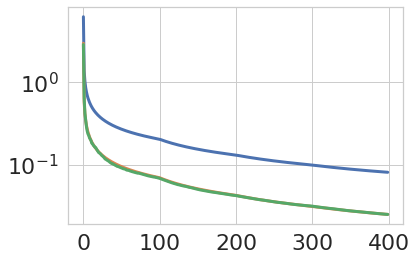

In [60]:
plt.yscale('log')
plt.plot(bound[:])
plt.plot(bound_avg[:])
plt.plot(bound_run_avg[:])

### Main plot call

In [79]:
def plot_stability_e2(bound, gen_error, x_values, path = None, type='mnist'):
    ## Resetting sns params
    if type == 'mnist':
        ylimit = (0.0000001, 500)
    elif type == 'fmnist':
        ylimit = (0.0005, 100)
    sns.set_theme()
    ## Applying locally
    with sns.axes_style('ticks'):
        sns.set_context('talk')
        plt.yscale('log')
        plt.plot(x_values, bound, label= 'Theoretical Upper Bound')
        plt.plot(x_values, np.abs(np.mean(gen_error, axis=0)), label='Observed Generalization Error')
        plt.xlabel('Number of Datapoints')
        plt.ylabel('Generalization error')
        plt.ylim(ylimit[0], ylimit[1])
        plt.legend()
        if path is not None:
            plt.savefig(path, bbox_inches='tight', dpi=300)
    return

### Running for main experiment

#### Mnist

In [82]:
root_dir = 'results/t1/'
path = 'try1_t10_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
bound_avg = get_bound(details,K_g_avg, L_g_avg) 
bound_run_avg=[]
for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
    kg, lg= K_g_run_avg[i], L_g_run_avg[i]
    m = t = x_values[i]
    alpha_0 = details['alpha_0']
    # print('m',m)
    bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))

print('Lp const:',K_g,'sm cons:', L_g)
# Using global average Lipschitz and smoothness
# plot_bound_gen_err(bound_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_avg.png')

# Using running average Lip and Sm
# plot_bound_gen_err(bound_run_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_run_avg.pdf')

# Using global max Lip and Sm
## Commented old plot function
# plot_bound_gen_err(bound, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist.pdf')

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
x value shape: (400,)
x value shape: (400,)
Lp const: 8.1174 sm cons: 58.185


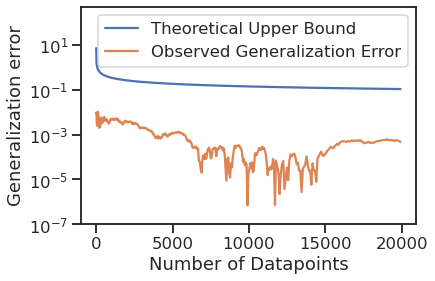

In [83]:
## New Plot
# plot_stability_e2(bound, gen_err_list, x_values, path='e2_generalization_error_mnist.pdf', type='mnist')
plot_stability_e2(bound, gen_err_list, x_values, path=None, type='mnist')

#### Fashion MNIST

In [10]:
root_dir = 'results/t2/'
path = 'try2f_t8_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
bound_avg = get_bound(details,K_g_avg, L_g_avg) 
bound_run_avg=[]
for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
    kg, lg= K_g_run_avg[i], L_g_run_avg[i]
    m = t = x_values[i]
    alpha_0 = details['alpha_0']
    # print('m',m)
    bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))

print('Lp const:',K_g,'sm cons:', L_g)
# Using global average Lipschitz and smoothness
# plot_bound_gen_err(bound_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_avg.png')

# Using running average Lip and Sm
# plot_bound_gen_err(bound_run_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_Fmnist_run_avg.png')

# Using global max Lip and Sm
## Commented old plot code
# plot_bound_gen_err(bound, gen_err_list, x_values=x_values, path='e2_generalization_error_Fmnist.pdf')

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
x value shape: (400,)
x value shape: (400,)
Lp const: 12.5737 sm cons: 102.7096


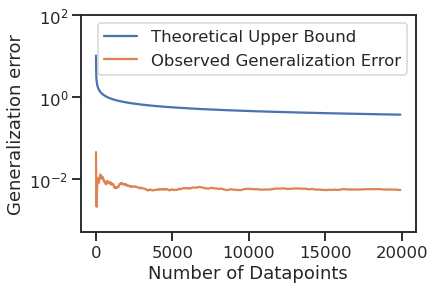

In [11]:
## New Plot
plot_stability_e2(bound, gen_err_list, x_values, path='e2_generalization_error_Fmnist.pdf', type='fmnist')

### MNIST TMLR version

In [11]:
root_dir = 'results/t1.1/'
path = 'try2_t10_r.4'
details = get_exp_details(root_dir, path)

grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
bound = get_bound(r_det=details, K_g=K_g, L_g=L_g)
print('------------------------------')

print('Max old paper values')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='arg_max')
prev_bound = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='arg_max')
print(f'{L_g=}, {L_s=}, {K_s=}')

print('------------------------------')
print('Avg lipschitz values')
L_g, L_s, K_s, x_values, gen_err_list = get_exp_results_tmlr(details, avg_lp='avg')
bound_avg = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='avg')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')

print('------------------------------')
print('Exact sum bound')
# L_g, L_s, K_s, x_values = get_exp_results_tmlr(details, avg_lp='avg')
bound_exact = get_bound_tmlr(r_det=details, L_s=L_s, L_g = L_g, K_s = K_s, avg_lg='exact_sum')
print(f'L_g={L_g.max()}, L_s={L_s.max()}, {K_s=}')
print('------------------------------')

# grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results_tmlr(details)
# grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details, alternate_analysis=True)
# bound = get_bound(r_det=details, K_g=K_g, L_g=L_g, version='TMLR')

# bound_avg = get_bound(r_det=details, K_g= K_g_run_avg, L_g=L_g, version='TMLR')

# bound_avg = get_bound(details,K_g_avg, L_g_avg) 
# bound_run_avg=[]
# for i in range(min(len(K_g_run_avg), len(L_g_run_avg))):
#     kg, lg= K_g_run_avg[i], L_g_run_avg[i]
#     m = t = x_values[i]
#     alpha_0 = details['alpha_0']
#     # print('m',m)
#     bound_run_avg.append(our_bound_computatio(kg, lg, t,m, alpha_0))

print('Lip consts:',L_g, L_s,'sm cons:', K_s)
# Using global average Lipschitz and smoothness
# plot_bound_gen_err(bound_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_avg.png')

# Using running average Lip and Sm
# plot_bound_gen_err(bound_run_avg, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist_run_avg.pdf')

# Using global max Lip and Sm
## Commented old plot function
# plot_bound_gen_err(bound, gen_err_list, x_values=x_values, path='e2_generalization_error_mnist.pdf')

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
x value shape: (400,)
------------------------------
Max old paper values
hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
L_g=8.1233, L_s=8.1233, K_s=58.1694
------------------------------
Avg lipschitz values
hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)
L_g=5.0253125, L_s=4.111578505270208, K_s=58.1694
------------------------------
Exact sum bound


/tmp/ipykernel_2649/2767396551.py:111: RuntimeWarning: divide by zero encountered in log
  rho = np.log(np.log(m))/np.log(m)


L_g=5.0253125, L_s=4.111578505270208, K_s=5.81694e+01
------------------------------
Lip consts: [3.5765    4.31975   3.2161125 3.758875  3.2269625 3.3037875 3.6098125
 4.3834375 3.5579125 3.9062875 3.924875  2.925875  4.520475  3.5792375
 4.1898375 3.4639875 4.4171    3.40545   3.4055125 3.529     3.39815
 3.901275  4.0469125 3.2722125 3.4533    4.002425  3.4890875 3.2866125
 2.9386625 3.4238875 3.9398375 3.67325   3.812725  3.658975  3.073
 3.4319125 3.439725  3.459     4.259525  3.3776875 3.6394125 3.6660375
 3.4147125 3.667     3.1857375 3.9603375 4.252925  3.4525625 3.8633375
 3.879975  3.3919375 4.0219    3.5373875 3.853     4.0917    4.11115
 2.74585   3.392575  4.0221125 3.870475  4.5430375 2.9824375 3.6562875
 3.2555375 4.196425  3.7181125 4.0741375 3.2485625 4.02105   4.1966625
 3.604     3.449825  4.6875875 4.4178625 3.7054875 3.7457875 3.4094125
 4.0537875 3.3115625 3.67465   3.319925  3.6345125 3.9068875 3.5434
 3.8856125 3.6665875 3.822425  3.8431875 3.1466375 3.7793875 4

In [10]:
details['alpha_0']

0.0001

In [57]:

result_dcit = {}
result_dcit['Lipschitz constant'] = K_g_run_avg #np.sqrt(np.mean(np.power(np.array(grad_list),2)))
result_dcit['Alternate Bound'] = bound_avg
result_dcit['Prev Bound'] = prev_bound
result_dcit['Generalization error'] =  np.abs(np.mean(gen_err_list, axis=0))
result_df = pd.DataFrame(result_dcit)
result_df.iloc[10::20]#.head(30)

,Lipschitz constant,Alternate Bound,Prev Bound,Generalization error
10,3.913086,0.498390,0.456586,0.001994
30,3.857161,0.474755,0.236918,0.004064
50,3.826686,0.403996,0.170828,0.004674
70,3.851244,0.469869,0.136874,0.005167
90,3.863868,0.456714,0.115663,0.003678
110,3.866411,0.587694,0.095121,0.003048
130,3.877382,0.631793,0.078012,0.001918
150,3.875538,0.490077,0.066772,0.000742
170,3.874692,0.590713,0.058738,0.001069
190,3.882692,0.523132,0.052666,0.001164


In [58]:
bound_exact.shape, bound_avg.shape, prev_bound.shape

((400,), (400,), (400,))

In [96]:
bound_avg

array([0.12296828, 0.20095545, 0.21261177, 0.23092176, 0.23362116,
       0.2354508 , 0.24214632, 0.2548221 , 0.25753789, 0.26319084,
       0.26936533, 0.2687879 , 0.27663863, 0.27776285, 0.28201414,
       0.28325724, 0.2882051 , 0.2880868 , 0.28813177, 0.28857033,
       0.28873813, 0.29114232, 0.29302473, 0.29289837, 0.29341193,
       0.29487866, 0.29491446, 0.29502353, 0.29436649, 0.29459161,
       0.29651121, 0.29733901, 0.29826754, 0.29882527, 0.29827035,
       0.29837832, 0.29858726, 0.29917688, 0.30103937, 0.30109611,
       0.30209165, 0.30267595, 0.30264771, 0.30331345, 0.30329977,
       0.30432349, 0.30571779, 0.30590401, 0.30647013, 0.30714341,
       0.30730982, 0.3085789 , 0.30862225, 0.30921719, 0.31015944,
       0.31149867, 0.31066485, 0.31065339, 0.31144947, 0.31210572,
       0.31372773, 0.31325634, 0.31365322, 0.31357991, 0.31472895,
       0.31523354, 0.3161125 , 0.31592567, 0.31667537, 0.31744207,
       0.31778382, 0.31791132, 0.31945917, 0.32062973, 0.32092

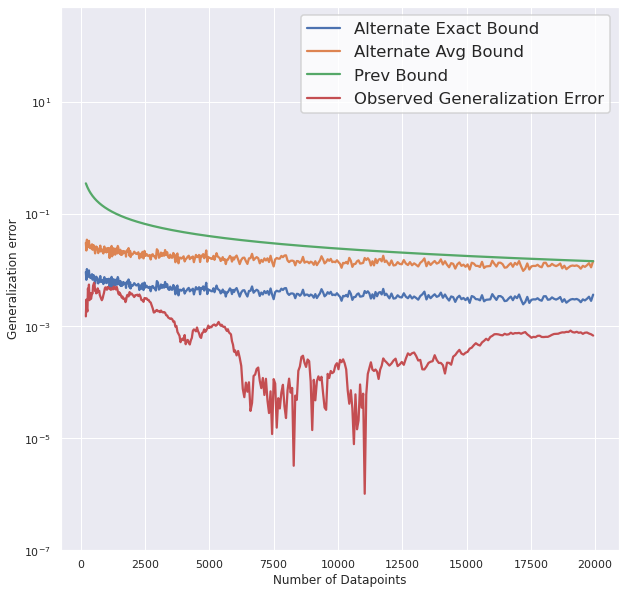

In [12]:
# Checking the difference in bounds.
ylimit = (0.0000001, 500)
sns.set_theme()
fig, ax = plt.subplots(figsize = (10,10))

## Applying locally
with sns.axes_style('ticks'):
    sns.set_context('talk')
    plt.yscale('log')
    plt.plot(x_values[10:], bound_exact[10:], label= 'Alternate Exact Bound')
    plt.plot(x_values[10:], bound_avg[10:], label= 'Alternate Avg Bound')
    plt.plot(x_values[10:], prev_bound[10:], label= 'Prev Bound')
    plt.plot(x_values[10:], np.abs(np.mean(gen_err_list, axis=0))[10:], label='Observed Generalization Error')
    plt.xlabel('Number of Datapoints')
    plt.ylabel('Generalization error')
    plt.ylim(ylimit[0], ylimit[1])
    plt.legend()

In [27]:
details

{'use_db': 'mnist',
 'result_root_dir': 'results/t1/',
 'result_path': 'try1_t10_r.4',
 'ratio': 0.4,
 'book_keep_freq': 20,
 'g_times': 8,
 'g_epochs': 1,
 'alpha_0': 0.001,
 'freq_reduce_by': 20,
 'freq_reduce_after': 100,
 'training_step_limit': '100000',
 'stop_hess_computation': '20000',
 'g_weight': 10}

## Plot EXP1 result (OLD, see EXP1 for latest plot )

In [83]:
def get_running_upper_bound(l, x_values=None):
    ub = [l[0]]
    ub_x = [0]
    if x_values is not None:
        ub_x = [x_values[0]]
    else:
        x_values = range(len(l))
    for l_i, x_v in zip(l[1:], x_values[1:]):
        if ub[-1]<l_i:
            ub.append(l_i)
            ub_x.append(x_v)
    ub_x.append(x_values[-1])
    ub.append(max(l[-1], ub[-1]))
    return {'x': ub_x, 'y': np.array(ub)}

def plot_e1(grad_list, hess_list, x_values=None, path=None):
    fig, ax =plt.subplots(figsize=(12,8))
    #ax1=fig.add_subplot(111, label="1")
    #ax2=fig.add_subplot(111, label="2", frame_on=False)
    fontsize = 24
    ticksize = 20
    line_width = 0.8
    marker_size = 12
    rotation = -30
    if x_values is None:
        x_values = range(len(grad_list[0]))
    sns.set_style("whitegrid")
    plt.ylim(2.5,6)
    plt.plot(x_values, np.mean(grad_list,0), 'orange', label='Actual values')
    ub_list = get_running_upper_bound(np.mean(grad_list,0), x_values)
    plt.plot(ub_list['x'],ub_list['y'] , 'red',label='Upper bound')
    
    plt.ylabel('Parameter Lipschitz constant', fontsize=fontsize)
    plt.xlabel('SGD Step', fontsize=fontsize)
    # plt.title('Mnist dataset', fontsize=fontsize)
    ax.legend()
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    plt.xticks(rotation=rotation)
    if path is not None:
        plt.savefig('e1_Lp_const_'+ path)
    else:
        plt.show()
    fig, ax =plt.subplots(figsize=(12,7))
    sns.set_style("whitegrid")
    plt.ylim(20,45)
    plt.plot(x_values, np.mean(hess_list,0),'green', label='Actual values')
    ub_list = get_running_upper_bound(np.mean(hess_list,0), x_values)
    plt.plot(ub_list['x'],ub_list['y'] , 'red', label='Upper bound')
    
    plt.ylabel('Parameter Smoothness constant', fontsize=fontsize)
    plt.xlabel('SGD Steps', fontsize=fontsize)
    ax.legend()
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    # plt.title('Mnist dataset', fontsize=fontsize)
    plt.xticks(rotation=rotation)
    if path is not None:
        plt.savefig('e1_sm_const_'+path)
    else:
        plt.show()

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


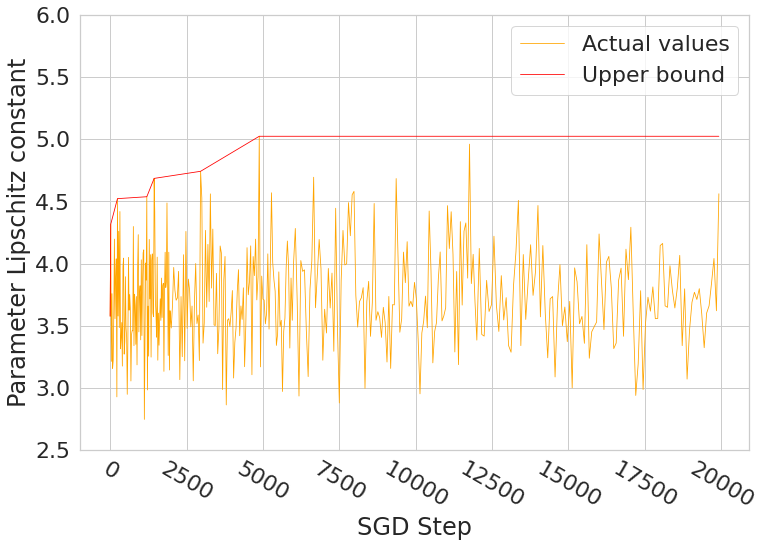

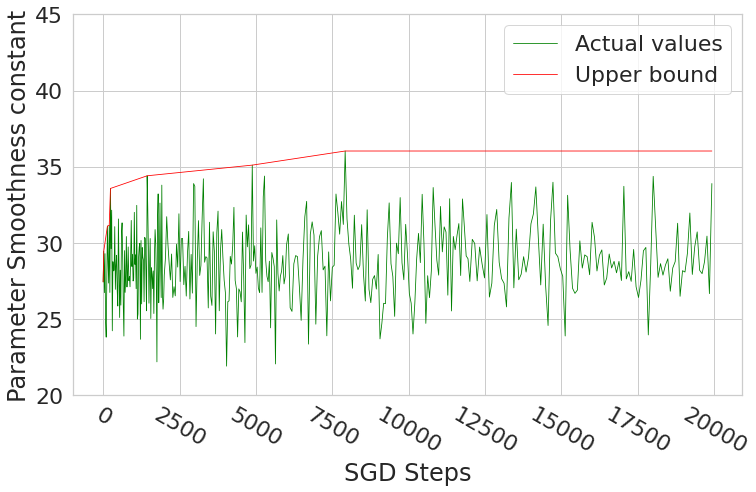

In [86]:
root_dir = 'results/t1/'
path = 'try1_t10_r.4'
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
plot_e1(grad_list, hess_list, x_values, path='mnist.png')